In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

RSA

In [3]:
class ModelRationalSpeechAct:
    

    def __init__(self, listener_beliefs, semantics, speaker_costs, alpha, listener_first=True) -> None:
        self.listener_beliefs = listener_beliefs
        self.listener_first = listener_first
        self.speaker_costs = speaker_costs
        self.alpha = alpha
        
        self.listener_n = 0
        self.speaker_n = 0

        if listener_first:
            self.listener_matrix = np.zeros(semantics.shape)
            for i in range(self.listener_matrix.shape[0]):
                self.listener_matrix[i] = (listener_beliefs*semantics[i])/np.dot(listener_beliefs, semantics[i])

            self.speaker_matrix = np.zeros(semantics.shape).transpose()
        else:
            self.listener_matrix = np.zeros(semantics.shape)

            self.speaker_matrix = np.zeros(semantics.shape).transpose()
            self.speaker_matrix = np.exp(self.alpha*(np.log(semantics.transpose()) \
                                  -np.repeat([speaker_costs], repeats=self.speaker_matrix.shape[0], axis=0)))
            for i in range(self.speaker_matrix.shape[0]):
                self.speaker_matrix[i] = self.speaker_matrix[i]/np.sum(self.speaker_matrix[i])


    def __update_listener(self):
        self.listener_n += 1
        for i in range(self.listener_matrix.shape[0]):
            self.listener_matrix[i] = (self.listener_beliefs*self.speaker_matrix.transpose()[i])/ \
                                        np.dot(self.listener_beliefs, self.speaker_matrix.transpose()[i])


    def __update_speaker(self):
        self.speaker_n += 1
        self.speaker_matrix = np.exp(self.alpha*(np.log(self.listener_matrix.transpose()) \
                                                 -np.repeat([self.speaker_costs], repeats=self.speaker_matrix.shape[0], axis=0)))
        for i in range(self.speaker_matrix.shape[0]):
            self.speaker_matrix[i] = self.speaker_matrix[i]/np.sum(self.speaker_matrix[i])


    def step(self):
        if self.listener_n < self.speaker_n:
            self.__update_listener()
        elif self.listener_n > self.speaker_n:
            self.__update_speaker()
        elif self.listener_first:
            self.__update_speaker()
        else:
            self.__update_listener()


    def n_step(self, n):
        for i in range(n):
            self.step()


    def show_step(self):
        if self.listener_n < self.speaker_n:
            self.__update_listener()
            print("L" + str(self.listener_n) + ":")
            print(self.listener_matrix)
        elif self.listener_n > self.speaker_n:
            self.__update_speaker()
            print('S' + str(self.speaker_n) + ":")
            print(self.speaker_matrix)
        elif self.listener_first:
            self.__update_speaker()
            print('S' + str(self.speaker_n) + ":")
            print(self.speaker_matrix)
        else:
            self.__update_listener()
            print("L" + str(self.listener_n) + ":")
            print(self.listener_matrix)


    def show_n_step(self, n):
        for i in range(n):
            self.show_step()


    def listener(self):
        return self.listener_matrix


    def stage_listener(self):
        return self.listener_n


    def speaker(self):
        return self.speaker_matrix


    def stage_speaker(self):
        return self.speaker_n

Accuracy

In [5]:
def make_no_ligne_null(matrix):
    for i in range(matrix.shape[0]):
        if np.all(matrix[i] == 0):
            matrix[i][random.randint(0, matrix.shape[1]-1)] = 1
    return matrix


def make_no_colones_null(matrix):
    for i in range(matrix.shape[1]):
        if np.all(matrix.transpose()[i] == 0):
            matrix[random.randint(0, matrix.shape[0]-1)][i] = 1
    return matrix


def random_semantic(matrix_size):
    return make_no_colones_null(make_no_ligne_null(np.random.choice([0,1], (matrix_size,matrix_size), p=[0.9,0.1])))


def expected_accuracy_rsa_model(rsa_model):
    return np.trace(np.matmul(rsa_model.listener().transpose(), rsa_model.speaker().transpose()))/rsa_model.listener().shape[0]


def expected_accuracy_list(semantic, points_differance):
    return_array = []
    number_states = semantic.shape[0]
    number_utterances = semantic.shape[0]
    rsa_model = ModelRationalSpeechAct(np.ones((number_states))/number_states, semantic, np.zeros((number_utterances)),1)
    rsa_model.step()

    return_array.append(expected_accuracy_rsa_model(rsa_model))
    for differance in points_differance:
        rsa_model.n_step(differance)
        return_array.append(expected_accuracy_rsa_model(rsa_model))

    return return_array


In [ ]:
points_differance = np.array([2 for i in range(25)])
matrix_sizes = [10,20,30,40,50]
graphs = []

for matrix_size in matrix_sizes:
    graphs.append(np.zeros(points_differance.shape[0]+1))
    for i in range(200):
        graphs[-1] += expected_accuracy_list(random_semantic(matrix_size), points_differance)
    graphs[-1] = graphs[-1]/200

Text(0.5, 0, 'N Recursions')

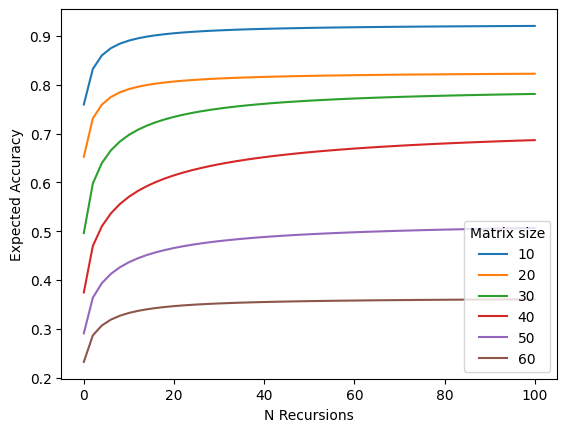

In [11]:
fig  = plt.figure()
ax = plt.subplot(111)
i = 1
for g in graphs:
    ax.plot([2*i for i in range(26)], g, label=str(10*i))
    i+= 1

ax.legend(title='Matrix size')
ax.set_ylabel('Expected Accuracy')
ax.set_xlabel('N Recursions')